<a href="https://colab.research.google.com/github/JingZ3321/awesome-django/blob/main/movie_genre_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

The movie genre classifier project aims to develop a predictive model capable of automatically assigning genres to movies based on their plot summaries. By leveraging natural language processing (NLP) techniques and machine learning algorithms, the classifier analyzes textual data to predict the genre(s) of a given movie.

# Data Description

The dataset used in this notebook was obtained from kaggle and it contains movie plot summaries scraped from wikipedia. The dataset has 34,886 entries.Information found in the datasetis as follows:

1. Release Year - year of release
2. Title - title of the movies
3. Origin/Ethnicity - country of origin of the movies
4. Director - director names associated with the movies
5. Cast - cast name associated with the movies
6. Genre - Movie Genre(s)
7. Wiki Page - wikipedia page of the movies
8. Plot - plot summary of the movies

# Data Exploration

# Import necessary libraries and packages

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import string
import spacy
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
import en_core_web_lg
nlp = spacy.load("en_core_web_lg")
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from yellowbrick.text import FreqDistVisualizer
!pip install yellowbrick
!pip install dataframe_image
import dataframe_image as dfi
from mlxtend.feature_selection import ColumnSelector
from collections import Counter
import collections
from matplotlib.pyplot import Figure
!pip install --upgrade scikit-learn

# Reading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
wiki= pd.read_csv('/content/drive/MyDrive/wiki_movie_plots_deduped.csv')

# Descriptive Statistics

In [ ]:
wiki.describe()

,Release Year
count,34886.000000
mean,1981.314252
std,27.815174
min,1901.000000
25%,1957.000000
50%,1988.000000
75%,2007.000000
max,2017.000000


In [ ]:
wiki.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [ ]:
wiki.shape

(34886, 8)

In [ ]:
wiki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


# Exploratory Data Analysis

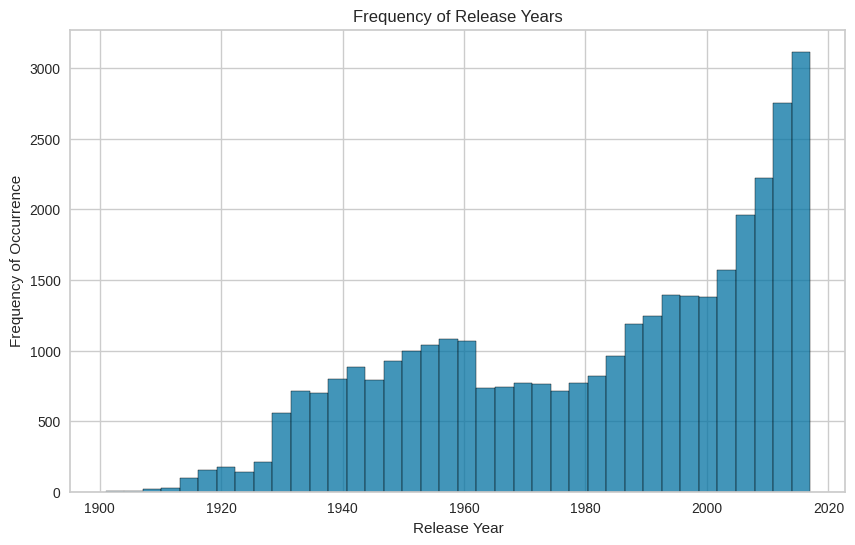

In [ ]:
# Movie Distributions by Release Year
plt.figure(figsize=(10,6))
sns.histplot(x = wiki['Release Year'])
plt.title('Frequency of Release Years')
plt.xlabel('Release Year')
plt.ylabel('Frequency of Occurrence')
plt.savefig('/content/drive/MyDrive/Images/FreqOfReleaseYear.png')
plt.show()

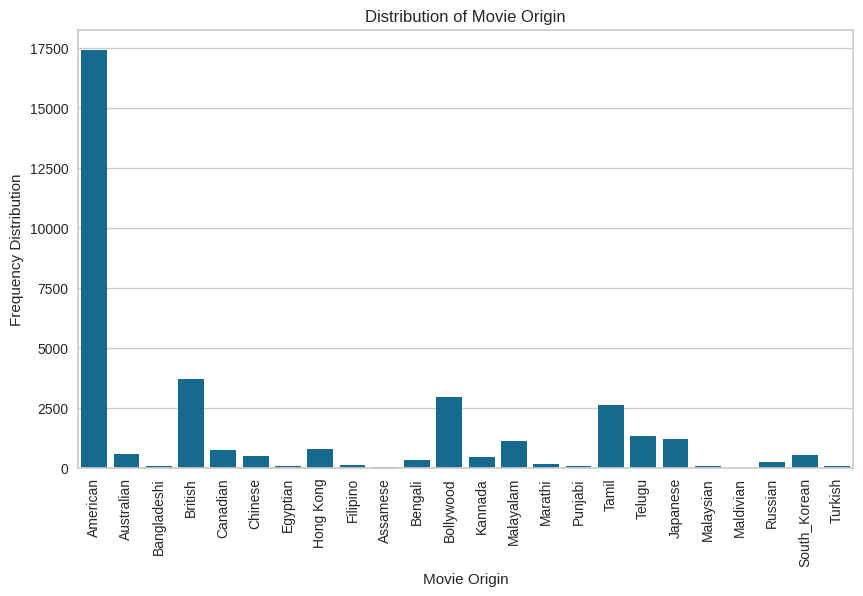

In [ ]:
# Movie distribution by Movie Origin
plt.figure(figsize=(10,6))
sns.countplot(x = wiki['Origin/Ethnicity'])
plt.title('Distribution of Movie Origin')
plt.xlabel('Movie Origin')
plt.ylabel('Frequency Distribution')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.15)
plt.savefig('/content/drive/MyDrive/Images/FreqDistOrigin.png')
plt.show()

# Subsetting and Describing the Dataset

In [ ]:
wiki_df = wiki.loc[wiki['Genre'] != 'unknown'].reset_index(drop=True)

# Checking the number of unique values we have in the genres column
print('There are', wiki_df['Genre'].nunique(), 'different Genres in the dataset:')
print('-'*50)
print(wiki_df['Genre'].value_counts())

There are 2264 different Genres in the dataset:
--------------------------------------------------
drama                            5964
comedy                           4379
horror                           1167
action                           1098
thriller                          966
                                 ... 
cbc-tv miniseries                   1
bio-drama                           1
national film board docudrama       1
cult drama                          1
horror romantic comedy              1
Name: Genre, Length: 2264, dtype: int64


In [ ]:
genres=pd.value_counts(wiki_df.Genre)
top_genres = pd.DataFrame(genres[:20]).reset_index()
top_genres.columns = ['genres', 'number_of_movies']
top_genres

,genres,number_of_movies
0,drama,5964
1,comedy,4379
2,horror,1167
3,action,1098
4,thriller,966
5,romance,923
6,western,865
7,crime,568
8,adventure,526
9,musical,467


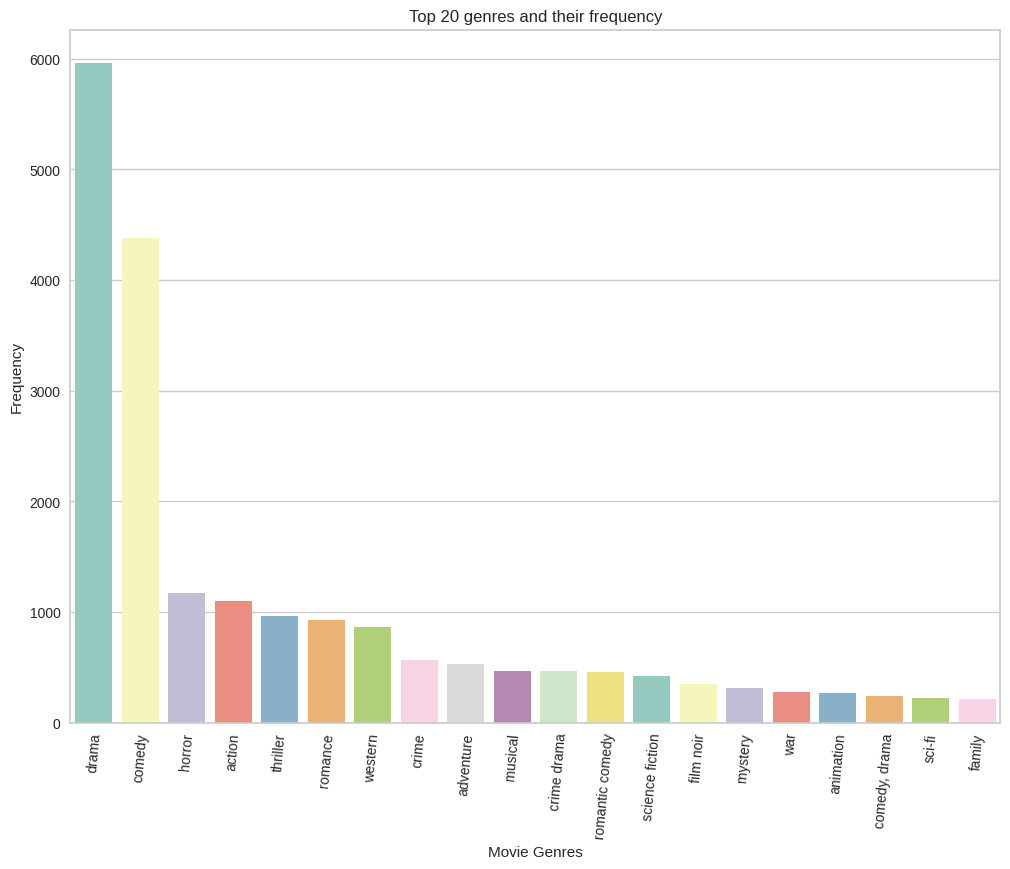

In [ ]:
# Movie distribution of the top 20 genres in the dataset
plt.figure(figsize=(12, 9))
plt.rc('font', size=14)
sns.barplot(data=top_genres, x="genres", y="number_of_movies", palette="Set3")
plt.title("Top 20 genres and their frequency")
plt.xlabel("Movie Genres")
plt.ylabel("Frequency")
plt.xticks(rotation=85)
plt.savefig("/content/drive/MyDrive/Images/FreqOfTopGenres.png")
plt.show()

In [ ]:
# Add a new column labeling movies with their top genre
conditions = [wiki_df['Genre']=='drama', wiki_df['Genre']=='comedy', wiki_df['Genre']=='horror', wiki_df['Genre']=='action', wiki_df['Genre']=='thriller', wiki_df['Genre']=='romance']
choices = [1,2,3,4,5,6]
wiki_df['labels'] = np.select(conditions, choices, 0)

In [ ]:
wiki_df.isna().any()

Release Year        False
Title               False
Origin/Ethnicity    False
Director            False
Cast                 True
Genre               False
Wiki Page           False
Plot                False
labels              False
dtype: bool

In [ ]:
wiki_df.sample(5)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,labels
12583,1997,Bongwater,American,Richard Sears,"Luke Wilson, Jack Black, Alicia Witt",comedy,https://en.wikipedia.org/wiki/Bongwater_(film),David (Luke Wilson) is a stoner living in Port...,2
2260,1937,Way Out West,American,James W. Horne,"Stan Laurel, Oliver Hardy, James Finlayson",comedy,https://en.wikipedia.org/wiki/Way_Out_West_(19...,"Stan and Oliver, after consorting with Seymore...",2
17614,1931,Hindle Wakes,British,Victor Saville,"Belle Chrystall, John Stuart",drama,https://en.wikipedia.org/wiki/Hindle_Wakes_(19...,Lancashire mill-girls Jenny Hawthorne (Chrysta...,1
27402,2011,Madatha Kaja,Telugu,Seetarama Raju,"Allari Naresh, Sneha Ullal","comedy, romance",https://en.wikipedia.org/wiki/Madatha_Kaja,Kalyan (Allari Naresh) is a happy going guy wh...,0
8570,1971,The Million Dollar Duck,American,Vincent McEveety,"Dean Jones, Sandy Duncan, Tony Roberts",family,https://en.wikipedia.org/wiki/The_Million_Doll...,Scientist Albert Dooley (Dean Jones) struggles...,0


In [ ]:
wiki_df['labels'].value_counts()

0    14306
1     5964
2     4379
3     1167
4     1098
5      966
6      923
Name: labels, dtype: int64

In [ ]:
df_to_use = (wiki_df.loc[wiki_df['labels']!=0]).reset_index(drop = True)

In [ ]:
df_to_use.describe()

,Release Year,labels
count,14497.000000,14497.000000
mean,1979.893909,2.275160
std,28.273607,1.528956
min,1904.000000,1.000000
25%,1956.000000,1.000000
50%,1988.000000,2.000000
75%,2006.000000,3.000000
max,2017.000000,6.000000


# Table showing Genre label assignments

In [ ]:
assigned_label = pd.DataFrame(sorted(list(zip(df_to_use['Genre'].unique(), df_to_use['labels'].unique())), key = lambda x : x[1], reverse = False), columns = ['genres', 'labels'])
pd.merge(assigned_label, top_genres)

,genres,labels,number_of_movies
0,drama,1,5964
1,comedy,2,4379
2,horror,3,1167
3,action,4,1098
4,thriller,5,966
5,romance,6,923


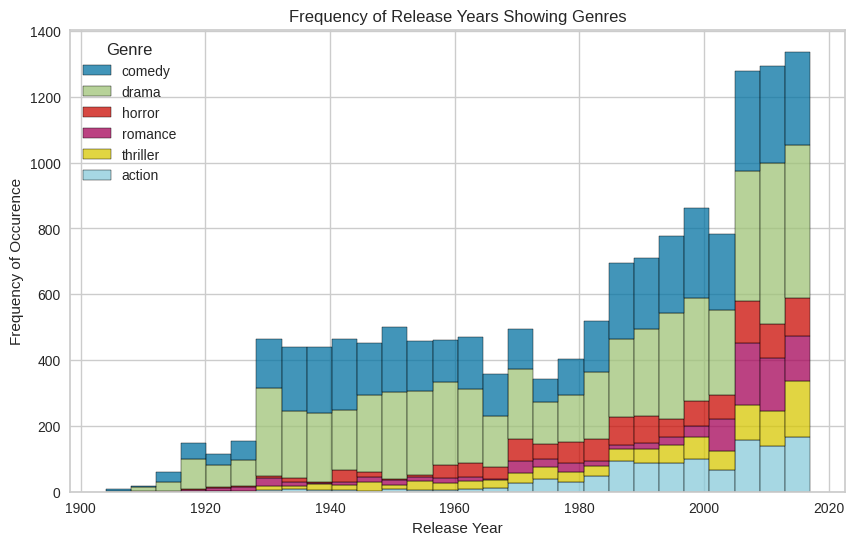

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

sns.histplot(x = 'Release Year', hue = 'Genre', data = df_to_use, multiple = 'stack')
plt.title('Frequency of Release Years Showing Genres')
plt.xlabel('Release Year')
plt.ylabel('Frequency of Occurence')
fig.savefig('/content/drive/MyDrive/Images/FreqOfReleaseYearandGenres.png');

# Remove unnecessary columns

In [ ]:
df_to_use.drop(columns = ['Release Year', 'Origin/Ethnicity', 'Director', 'Cast', 'Wiki Page'], axis = 1, inplace = True)

df_to_use.columns

Index(['Title', 'Genre', 'Plot', 'labels'], dtype='object')

In [ ]:
df_to_use

,Title,Genre,Plot,labels
0,The Suburbanite,comedy,The film is about a family who move to the sub...,2
1,How Brown Saw the Baseball Game,comedy,Before heading out to a baseball game at a nea...,2
2,Laughing Gas,comedy,The plot is that of a black woman going to the...,2
3,The Adventures of Dollie,drama,On a beautiful summer day a father and mother ...,1
4,The Black Viper,drama,A thug accosts a girl as she leaves her workpl...,1
...,...,...,...,...
14492,White as Snow,drama,Hasan is a twelve-year-old boy living with his...,1
14493,Once Upon a Time in Anatolia,drama,"Through the night, three cars carry a small gr...",1
14494,Selam,drama,The film opens with a Senegalese boy named Kha...,1
14495,Çalgı Çengi İkimiz,comedy,"Two musicians, Salih and Gürkan, described the...",2


# Text Preprocessing for Plot Summaries

In [ ]:
# Define stopwords list
stopwords_list = set(stopwords.words('english'))
stopwords_list |= set(string.punctuation)
stopwords_list |= set(['one', 'two', 'go', 'goes', 'get', 'also', 'however', 'tells', 'I'])
stopwords_list |= set(['0', '1', '2', '3', '4', '5', '6', '7', '8'])

def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Replace contractions
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ",text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\d+', ' ', text)

    # Remove special characters
    text = re.sub(pattern='[^a-zA-Z]', repl=' ', string=text)

    text = text.strip(' ')

    # Tokenize text
    text = word_tokenize(text)
    text = ' '.join(text)
    text = nlp(text)

    # Lemmatize words
    text = [w.lemma_ for w in text]

    # Remove stopwords
    text = [w for w in text if w not in stopwords_list]

    # Join tokens back into a string
    text = ' '.join(text)
    return text

In [ ]:
new_df = df_to_use.copy(deep = True)

In [ ]:
new_df['Plot'] = new_df['Plot'].apply(clean_text)

## Top 20 Most Common Words in Plot Summaries

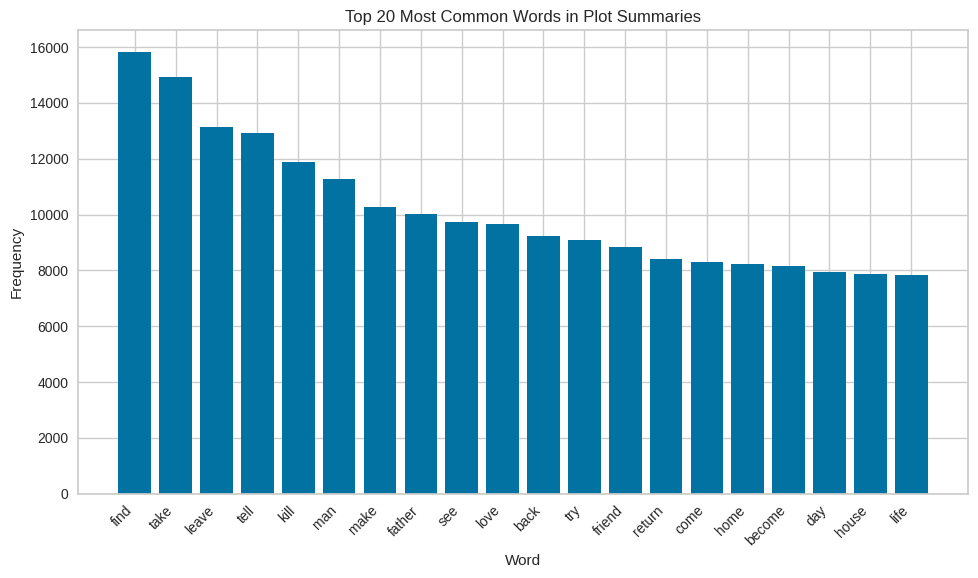

In [ ]:
fig = Figure(figsize=(10,6))

# Tokenize the cleaned plot summaries
tokenized_plots = new_df['Plot'].apply(lambda x: x.split())

# Flatten the list of tokens
all_tokens = [token for sublist in tokenized_plots for token in sublist]

# Calculate word frequencies
word_freq = Counter(all_tokens)

# Plot the top N most common words
top_n = 20
top_words = word_freq.most_common(top_n)
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_words_df['Word'], top_words_df['Frequency'])
plt.title('Top 20 Most Common Words in Plot Summaries')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
fig.savefig('/content/drive/MyDrive/Images/Top20TF-IDFWords.png');

# DRAMA

## Frequency Distribution plot showing the 10 most common words in the plot summaries in drama

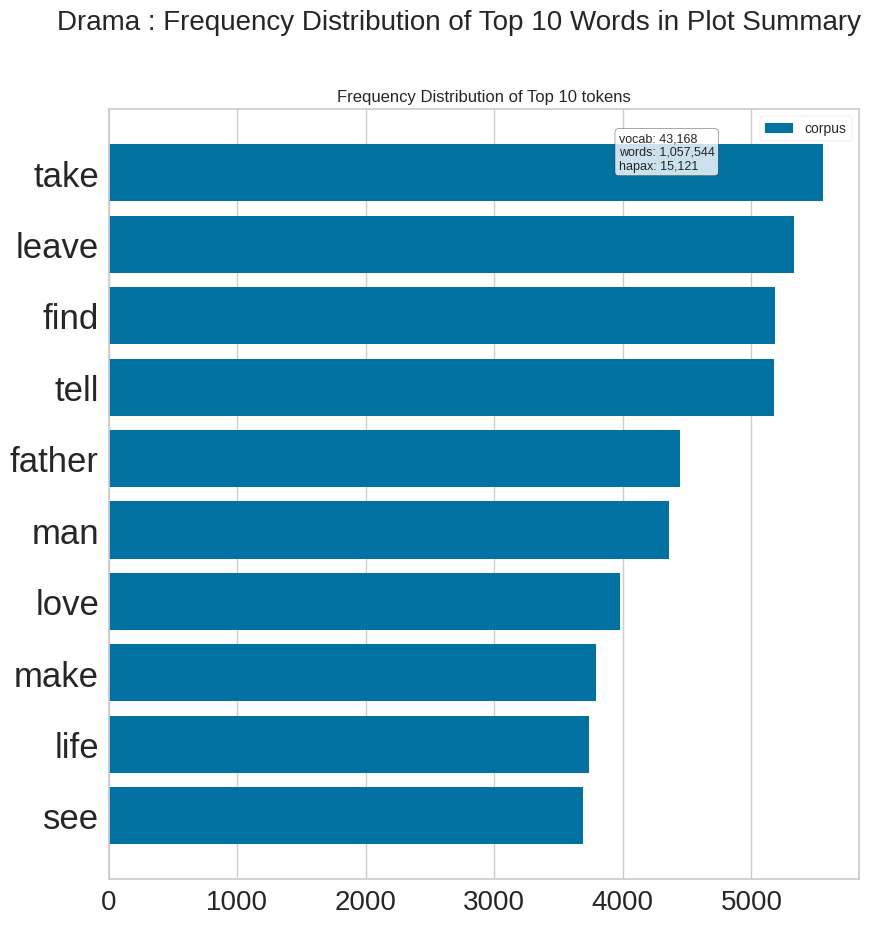

In [ ]:
drama_plot = new_df.loc[new_df['labels'] == 1, ['Plot', 'Title']]
drama_plotlist = [x for x in drama_plot['Plot'].str.split()]
drama_plotlist = list(itertools.chain(*drama_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(drama_plotlist)
features   = count.get_feature_names_out()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Drama : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show()
fig.savefig('/content/drive/MyDrive/Images/FreqDistTop10ForDrama.png');

# COMEDY

## Frequency Distribution plot showing the 10 most common words in the plot summaries in comedy

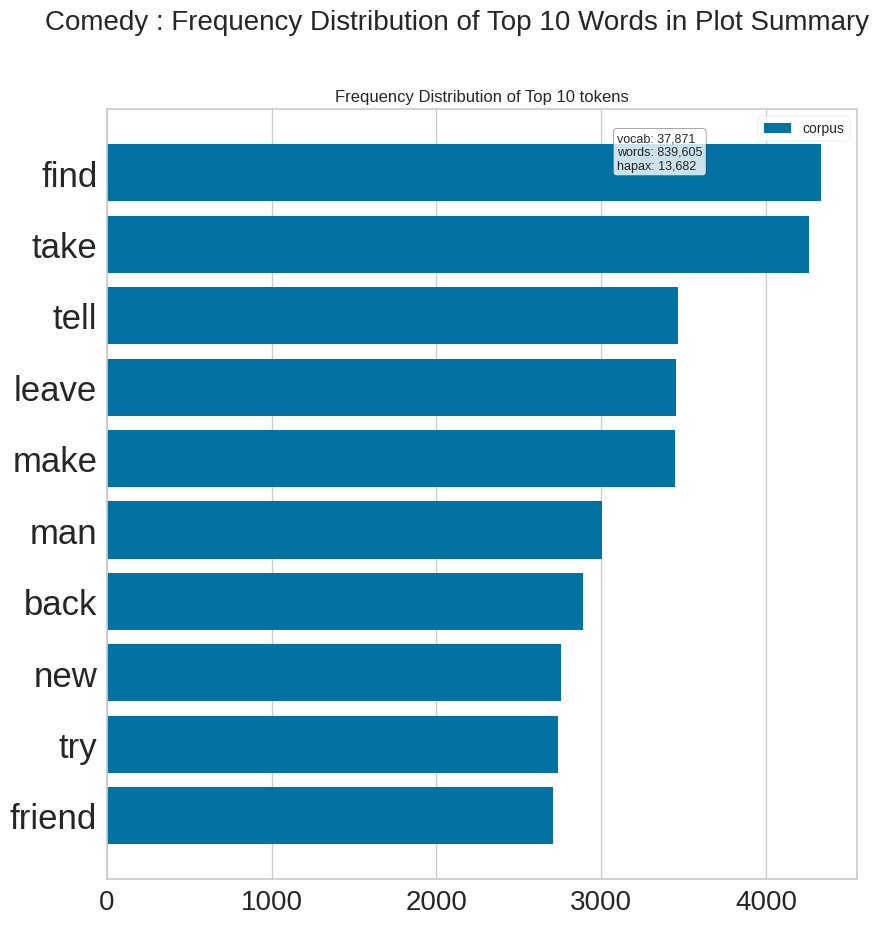

In [ ]:
comedy_plot = new_df.loc[new_df['labels'] == 2, ['Plot', 'Title']]
comedy_plotlist = [x for x in comedy_plot['Plot'].str.split()]
comedy_plotlist = list(itertools.chain(*comedy_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(comedy_plotlist)
features   = count.get_feature_names_out()

fig = plt.figure(figsize=(10, 10))
plt.suptitle('Comedy : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show()
fig.savefig('/content/drive/MyDrive/Images/FreqDistTop10ForComedy.png');

# HORROR

## Frequency Distribution plot showing the 10 most common words in the plot summaries in horror

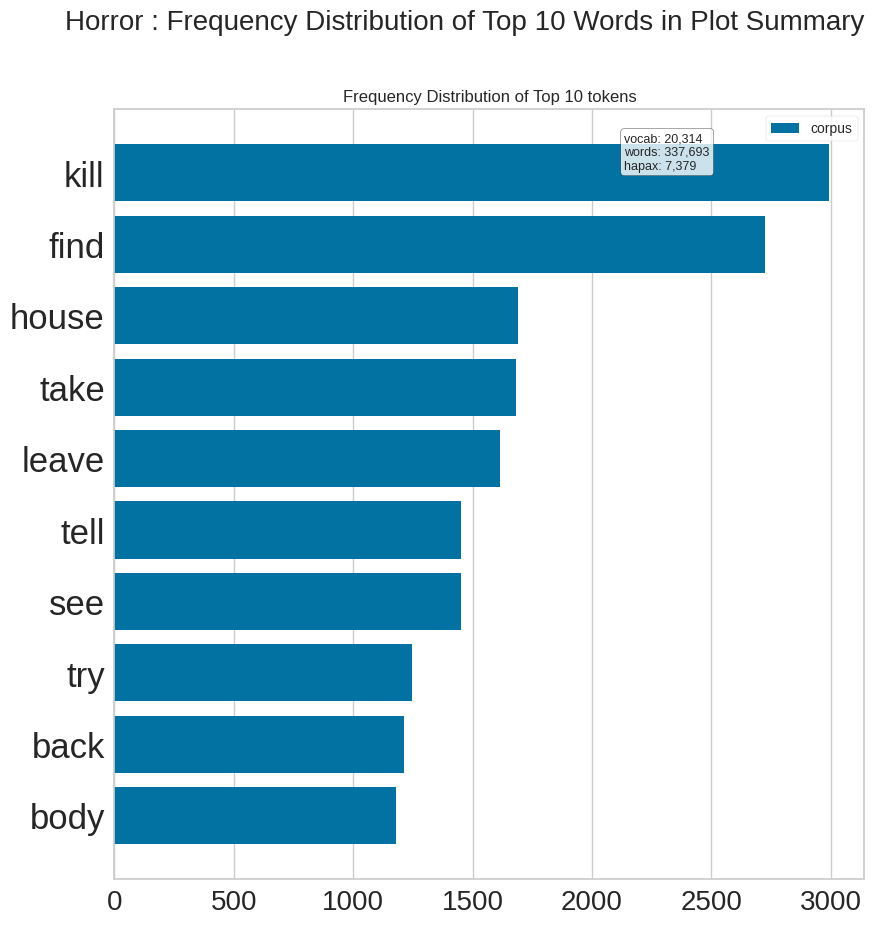

In [ ]:
horror_plot = new_df.loc[new_df['labels'] == 3, ['Plot','Title']]
horror_plotlist = [x for x in horror_plot['Plot'].str.split()]
horror_plotlist = list(itertools.chain(*horror_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(horror_plotlist)
features   = count.get_feature_names_out()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Horror : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show()
fig.savefig('/content/drive/MyDrive/Images/FreqDistTop10ForHorror.png');

# ACTION

## Frequency Distribution plot showing the 10 most common words in the plot summaries in action

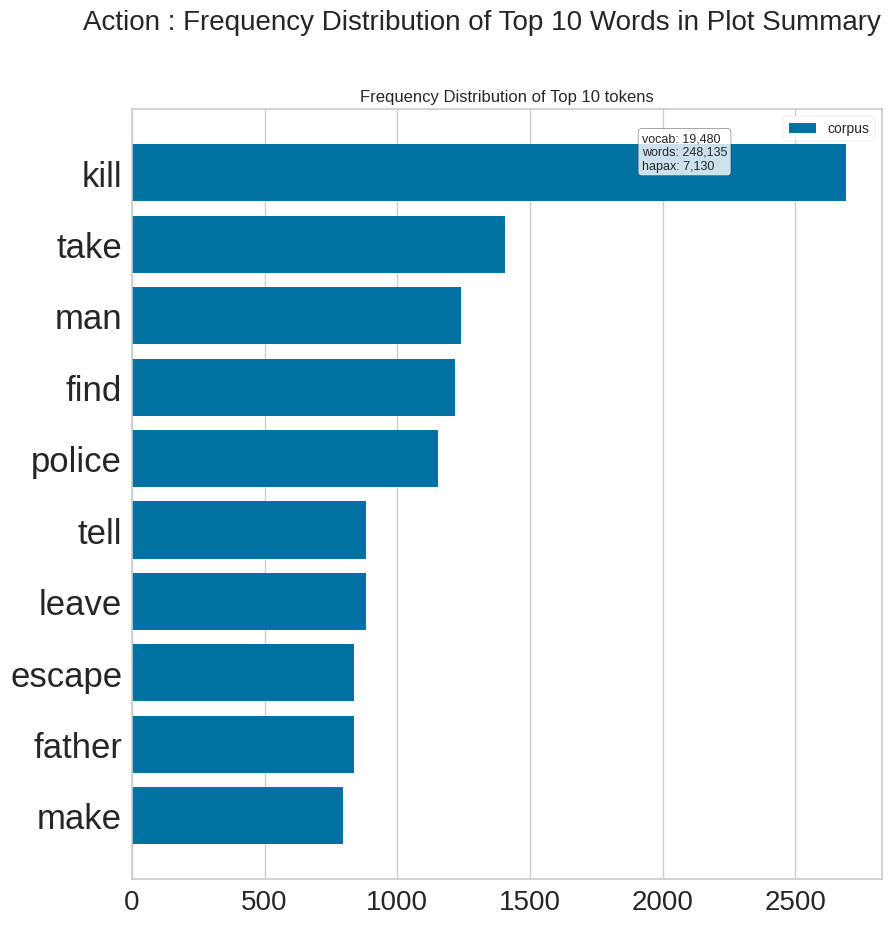

In [ ]:
action_plot = new_df.loc[new_df['labels'] == 4, ['Plot', 'Title']]
action_plotlist = [x for x in action_plot['Plot'].str.split()]
action_plotlist = list(itertools.chain(*action_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(action_plotlist)
features   = count.get_feature_names_out()

fig = plt.figure(figsize=(10, 10))
plt.suptitle('Action : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show()
fig.savefig('/content/drive/MyDrive/Images/FreqDistTop10ForAction.png');

# THRILLER

## Frequency Distribution plot showing the 10 most common words in the plot summaries in thriller

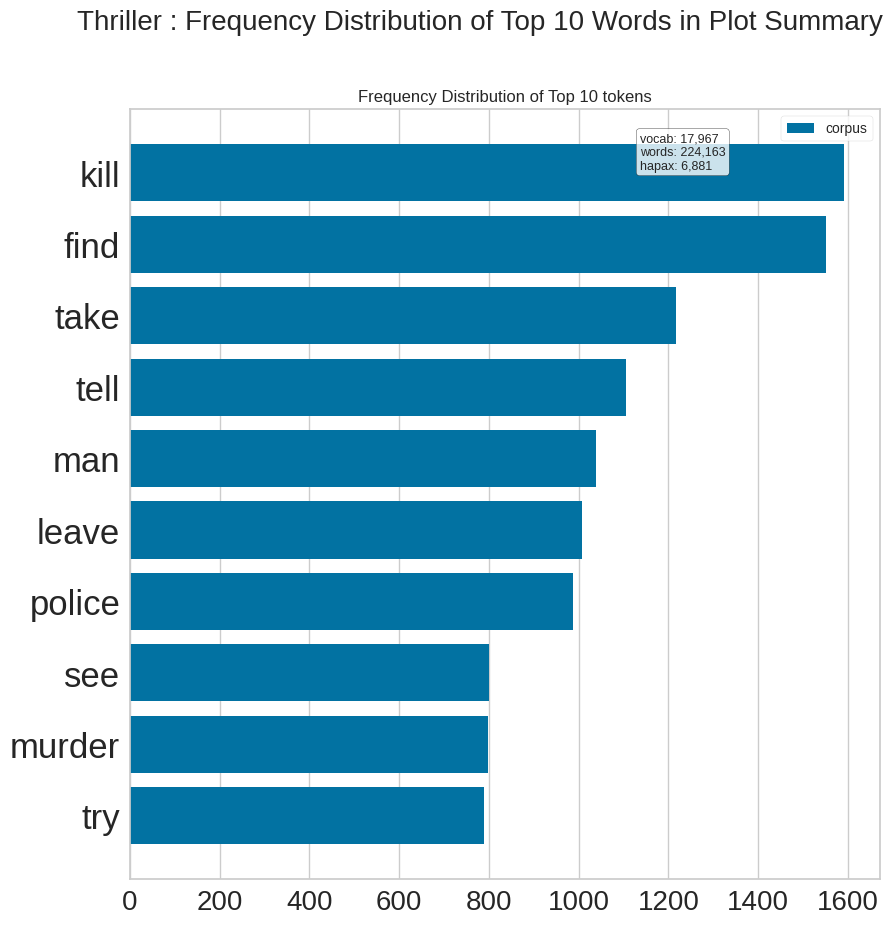

In [ ]:
thriller_plot = new_df.loc[new_df['labels'] == 5, ['Plot']]
thriller_plotlist = [x for x in thriller_plot['Plot'].str.split()]
thriller_plotlist = list(itertools.chain(*thriller_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(thriller_plotlist)
features   = count.get_feature_names_out()

fig = plt.figure(figsize=(10, 10))
plt.suptitle('Thriller : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show()
fig.savefig('/content/drive/MyDrive/Images/FreqDistTop10ForThriller.png');

# ROMANCE

## Frequency Distribution plot showing the 10 most common words in the plot summaries in romance

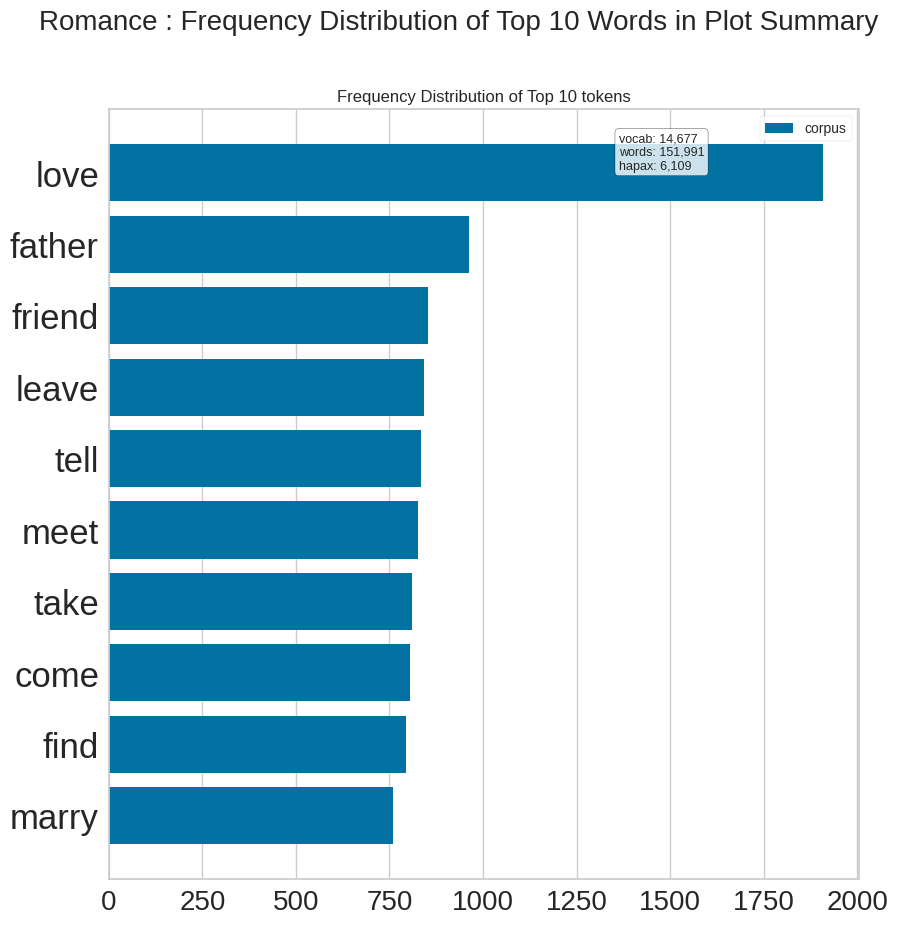

In [ ]:
romance_plot = new_df.loc[new_df['labels'] == 6, ['Plot','Title']]
romance_plotlist = [x for x in romance_plot['Plot'].str.split()]
romance_plotlist = list(itertools.chain(*romance_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(romance_plotlist)
features   = count.get_feature_names_out()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Romance : Frequency Distribution of Top 10 Words in Plot Summary', size = 20)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=10, orient='h')
visualizer.fit(docs)
visualizer.show()
fig.savefig('/content/drive/MyDrive/Images/FreqDistTop10ForRomance.png');

# Split the data

In [ ]:
# Define X and y
X = new_df['Plot']
y = new_df['labels']

# Split the data using StratifiedShuffleSplit
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=42)
for train_index, test_index in stratified_split.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Transform X_train and X_test into lists to pass to a TfidfVectorizer
train_x = [x.strip() for x in X_train.tolist()]
test_x = [x.strip() for x in X_test.tolist()]

print(len(train_x), len(test_x), y_train.shape, y_test.shape)

9712 4785 (9712,) (4785,)


# Model Training and Evaluation

# Using TfidfVectorizer on the independent variable and testing out the Multinomial Naive Bayes Model, SVM linear, and Logistic Regression Model

## Multinomial Naive Bayes

In [ ]:
stop_words = "english"

# Pipeline and parameters for Multinomial Naive Bayes
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', MultinomialNB())
])

parameters_nb = {
    'tfidf__max_df': (0.25, 0.5),
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': (1e-2, 1e-3)
}

## SVM linear

In [ ]:
# Pipeline and parameters for Linear SVM
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', LinearSVC())
])

# Define the parameters for tuning
parameters_svm = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': [0.01, 0.1, 1],
    'clf__class_weight': ['balanced', None],
}

## Logistic Regression

In [ ]:
# Pipeline and parameters for Logistic Regression
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', LogisticRegression(solver='sag'))
])

# Define the parameters for tuning
parameters_lr = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': [0.01, 0.1, 1],
    'clf__class_weight': ['balanced', None],
}

## Tunning through GridSearchCV for each classifier

In [ ]:
# GridSearchCV for each classifier
grid_search_tune_nb = GridSearchCV(
    pipeline_nb, parameters_nb, cv=2, n_jobs=1, verbose=3)
grid_search_tune_svm = GridSearchCV(
    pipeline_svm, parameters_svm, cv=2, n_jobs=1, verbose=3)
grid_search_tune_lr = GridSearchCV(
    pipeline_lr, parameters_lr, cv=2, n_jobs=1, verbose=3)

In [ ]:
# Fit the classifiers
grid_search_tune_nb.fit(train_x, y_train)
grid_search_tune_svm.fit(train_x, y_train)
grid_search_tune_lr.fit(train_x, y_train)

## Results

In [ ]:
genres = ['drama', 'comedy', 'comedy', 'action', 'thriller', 'romance']

# Print best parameters and performance on test set for each classifier
print("Best parameters for Multinomial Naive Bayes:")
print(grid_search_tune_nb.best_estimator_.steps)
print("Classification report for Multinomial Naive Bayes:")
print(classification_report(y_test, grid_search_tune_nb.predict(test_x), target_names=genres))

print("Best parameters for Linear SVM:")
print(grid_search_tune_svm.best_estimator_.steps)
print("Classification report for Linear SVM:")
print(classification_report(y_test, grid_search_tune_svm.predict(test_x), target_names=genres))

print("Best parameters for Logistic Regression:")
print(grid_search_tune_lr.best_estimator_.steps)
print("Classification report for Logistic Regression:")
print(classification_report(y_test, grid_search_tune_lr.predict(test_x), target_names=genres))

Best parameters for Multinomial Naive Bayes:
[('tfidf', TfidfVectorizer(max_df=0.5, ngram_range=(1, 2), stop_words='english')), ('clf', MultinomialNB(alpha=0.001))]
Classification report for Multinomial Naive Bayes:
              precision    recall  f1-score   support

       drama       0.60      0.77      0.67      1969
      comedy       0.64      0.62      0.63      1445
      comedy       0.79      0.67      0.73       385
      action       0.60      0.37      0.46       362
    thriller       0.38      0.07      0.12       319
     romance       0.43      0.34      0.38       305

    accuracy                           0.61      4785
   macro avg       0.57      0.47      0.50      4785
weighted avg       0.60      0.61      0.59      4785

Best parameters for Linear SVM:
[('tfidf', TfidfVectorizer(max_df=0.5, ngram_range=(1, 2), stop_words='english')), ('clf', LinearSVC(C=1, class_weight='balanced'))]
Classification report for Linear SVM:
              precision    recall  f1-

# Applying SVM Linear Model with TfidfVectorizer Pipeline to the test set

In [ ]:
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', LinearSVC())
])

# Fit the TF-IDF vectorizer on the training data
pipeline_svm.fit(X_train, y_train)

# Apply the Linear SVM model pipeline to the test set
predictions_svm = pipeline_svm.predict(X_test)

# Print the classification report for Linear SVM
print("Classification Report for Linear SVM Model:")
print(classification_report(y_test, predictions_svm))

Classification Report for Linear SVM Model:
              precision    recall  f1-score   support

           1       0.63      0.75      0.69      1969
           2       0.65      0.67      0.66      1445
           3       0.74      0.72      0.73       385
           4       0.54      0.41      0.47       362
           5       0.38      0.13      0.19       319
           6       0.44      0.25      0.32       305

    accuracy                           0.63      4785
   macro avg       0.56      0.49      0.51      4785
weighted avg       0.61      0.63      0.61      4785



# Conclusion

## Model Performance:

*   Linear SVM model achieved the highest accuracy among the three classifiers with an accuracy of around 65%.
*   Multinomial Naive Bayes and Logistic Regression models performed slightly worse, with accuracies around 61%.

## Feature Importance:

*   The models were trained on TF-IDF vectors of the plot summaries. Certain words or combinations of words might have been more indicative of certain genres, contributing to the models' predictive performance.
*   Future analysis could involve examining feature importances or coefficients from the models to understand which words or phrases are most influential in predicting specific genres.

## Hyperparameter Tuning:

*   Hyperparameter tuning improved the performance of the models to some extent. However, there might still be room for further optimization, especially considering different parameter combinations or using more advanced techniques like ensemble methods.

# Further Steps:

*   The project could benefit from additional data preprocessing techniques, such as experimenting with different text cleaning methods or incorporating more advanced NLP features like word embeddings.
*   Exploring other machine learning algorithms or ensemble methods could potentially improve performance further.

